In [1]:
!pip install geopy
!pip install tqdm
!wget https://restb-hackathon.s3.amazonaws.com/real_estate_dataset/hackupc2023_restbai__dataset.zip
!unzip /content/hackupc2023_restbai__dataset.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2023-05-14 04:38:07--  https://restb-hackathon.s3.amazonaws.com/real_estate_dataset/hackupc2023_restbai__dataset.zip
Resolving restb-hackathon.s3.amazonaws.com (restb-hackathon.s3.amazonaws.com)... 52.218.56.154, 52.218.97.74, 52.218.53.97, ...
Connecting to restb-hackathon.s3.amazonaws.com (restb-hackathon.s3.amazonaws.com)|52.218.56.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90333469 (86M) [application/zip]
Saving to: ‘hackupc2023_restbai__dataset.zip.2’

          hackupc20   0%[                    ]       0  --.-KB/s               ^C
Archive:  /content/hackupc2023_restbai__dataset.zip
replace hackupc2023_restbai__dataset/hackupc2023_restbai__dataset_sample.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
import json
import pandas as pd
import numpy as np
import read_json
from sklearn.cluster import KMeans
from tqdm import tqdm
import pickle
from sklearn.metrics import jaccard_score
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from numpy import isnan
from pandas import read_csv
from sklearn.impute import KNNImputer
from scipy.cluster.hierarchy import linkage,dendrogram,cut_tree
from sklearn.decomposition import KernelPCA
import sys
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

In [3]:
df = read_json.read_dataset("/content/hackupc2023_restbai__dataset/hackupc2023_restbai__dataset.json")

In [4]:
# transpose the df 
df = df.T

In [5]:
# subset of the original dataset for memory issues
df = df[df['neighborhood'] == 'Les Franqueses del Vallès']
df

,summary,city,neighborhood,region,price,square_meters,bedrooms,bathrooms,images,num_images,image_data,property_type
21200,"Dúplex en Carrer de Girona, cerca de Carrer de...",Bellavista,Les Franqueses del Vallès,barcelona,320000,188,4,2,[https://restb-hackathon.s3.amazonaws.com/real...,1,"{'r1r6': {'property': 2.4, 'kitchen': None, 'b...",condo_apartment
21203,Piso en Pabellon,Corró d'Avall,Les Franqueses del Vallès,barcelona,205000,85,3,2,[https://restb-hackathon.s3.amazonaws.com/real...,1,"{'r1r6': {'property': None, 'kitchen': None, '...",condo_apartment
21204,Dúplex en Pabellon,Corró d'Avall,Les Franqueses del Vallès,barcelona,288000,128,4,3,[https://restb-hackathon.s3.amazonaws.com/real...,1,"{'r1r6': {'property': None, 'kitchen': None, '...",condo_apartment
21476,Piso en Carretera de Ribes,Corró d'Avall,Les Franqueses del Vallès,barcelona,193950,130,4,2,[https://restb-hackathon.s3.amazonaws.com/real...,1,"{'r1r6': {'property': None, 'kitchen': None, '...",condo_apartment
21851,"Piso en Carrer del Terme, nº 19",Bellavista,Les Franqueses del Vallès,barcelona,159000,53,2,1,[https://restb-hackathon.s3.amazonaws.com/real...,22,"{'r1r6': {'property': 3.6, 'kitchen': 3.7, 'ba...",condo_apartment
...,...,...,...,...,...,...,...,...,...,...,...,...
831357,"Dúplex en Carrer de Girona, cerca de Carrer de...",Bellavista,Les Franqueses del Vallès,valles_oriental_sud,320000,188,4,2,[https://restb-hackathon.s3.amazonaws.com/real...,1,"{'r1r6': {'property': 2.4, 'kitchen': None, 'b...",condo_apartment
831359,Dúplex en Carrer de Torre Pinòs,Bellavista,Les Franqueses del Vallès,valles_oriental_sud,255000,98,3,2,[https://restb-hackathon.s3.amazonaws.com/real...,1,"{'r1r6': {'property': 2.4, 'kitchen': None, 'b...",condo_apartment
831361,Dúplex en Corró d'Avall,Corró d'Avall,Les Franqueses del Vallès,valles_oriental_sud,337000,144,3,2,[https://restb-hackathon.s3.amazonaws.com/real...,1,"{'r1r6': {'property': 3.5, 'kitchen': 3.5, 'ba...",condo_apartment
831423,Finca rústica en Corró d'Avall,Corró d'Avall,Les Franqueses del Vallès,valles_oriental_sud,1100000,1000,8,5,[https://restb-hackathon.s3.amazonaws.com/real...,1,"{'r1r6': {'property': None, 'kitchen': None, '...",single_family


In [6]:
'Removes nested dictionaries in order to obtain the image_data information'
def nodict(data, i, name):
  if type(data) == list and len(data) > 0 and type(data[0]) == dict:
    for elem in data:
      l = list(elem.values())
      if l[0] == 'unique_features':
        s=''
        s2 = ''
      elif name == '': 
        s=''
        s2 = l[0]
      else: 
        s='.'
        s2 = l[0]
      df.at[df.index[i], name + s + s2] = [["Yes"]]
      df.at[df.index[i], name + s + s2] = l[1]
  elif type(data) != dict:
    df.at[df.index[i], name] = [["Yes"]]
    df.at[df.index[i], name] = data
  else:
    for item in data.items():
      if item[0] == 'unique_features':
        s=''
        s2 = ''
      elif name == '': 
        s=''
        s2 = item[0]
      else: 
        s='.'
        s2 = item[0]
      nodict(item[1], i, name + s + s2)

In [7]:
def compute_clusters(df, nclusters):

  # all the nested df fields are converted in columns of the new df at the same level
  for i in range (df.shape[0]):
    imgdat = df.loc[df.index[i], 'image_data']
    categs = [k for k in imgdat.keys()]
    for categ in categs[0:2]:
      for item in imgdat[categ].items():
        new_str = categ + '.' + item[0]
        df.loc[df.index[i], new_str] = item[1]
    nodict(imgdat[categs[2]], i, '')

  # truncate the df to obtain the features_by_room_type information
  df = df.iloc[:, 18:]

  # drop best_photo_idx information as we do not use it
  cols_to_drop = [col for col in df.columns if 'best_photo_idx' in col]

  # drop the columns
  df = df.drop(cols_to_drop, axis=1)

  # add the subcategory 'standard' to those samples which do not have category
  for col in df.columns:
      # Split the column name into category and subcategory
      category, subcategory = col.split('.') if '.' in col else (col, 'standard')
      # Create a new column name with category.subcategory
      new_col = f'{category}.{subcategory}'
      # Rename the column in df
      df.rename(columns={col: new_col}, inplace=True)

  # Replace NaN values with 0, and non-NaN values with 1
  df = df.apply(lambda x: (~pd.isna(x)).astype(int))

  # compute the total number of non-NaN values for each category.subcategory combination
  non_nan_counts = df.count()

  # split the column names into category and subcategory
  col_names = df.columns
  categories = set([col.split(".")[0] for col in col_names])
  subcategories_dict = {cat: [col.split(".")[1] for col in col_names if col.startswith(cat+".")] for cat in categories}

  # select the 7 categories with the highest counts
  top_categories = sorted(categories, key=lambda cat: -sum([non_nan_counts[f"{cat}.{subcat}"] for subcat in subcategories_dict[cat]]))[:7]

  # extract the binary values for the selected categories
  df_top = pd.concat([df[[f"{cat}.{subcat}" for subcat in subcategories_dict[cat]]] for cat in top_categories], axis=1)

  # perform KMeans clustering
  kmeans = KMeans(n_clusters=nclusters)
  kmeans.fit(df_top)

  # get the cluster labels
  cluster_labels = kmeans.labels_

  return cluster_labels

In [8]:
clusters = compute_clusters(df, 5)
df['clusters'] = clusters
df['clusters']

21200     1
21203     1
21204     1
21476     1
21851     2
         ..
831357    1
831359    1
831361    1
831423    1
831435    1
Name: clusters, Length: 359, dtype: int32

In [9]:
cities = []
# Load data from cities.pkl
with open('cities.pkl', 'rb') as file:
    cities = pickle.load(file)


In [10]:
list(df.columns)

['summary',
 'city',
 'neighborhood',
 'region',
 'price',
 'square_meters',
 'bedrooms',
 'bathrooms',
 'images',
 'num_images',
 'image_data',
 'property_type',
 'r1r6.property',
 'r1r6.kitchen',
 'r1r6.bathroom',
 'r1r6.interior',
 'style.label',
 'style.confidence',
 'dining_room.hardwood_floor',
 'dining_room.natural_light',
 'dining_room.best_photo_idx',
 'balcony.balcony',
 'balcony.best_photo_idx',
 'terrace.fence',
 'terrace.best_photo_idx',
 'outdoor_building.fence',
 'outdoor_building.best_photo_idx',
 'empty_room.hardwood_floor',
 'empty_room.natural_light',
 'empty_room.washer__dryer',
 'empty_room.floor_ceiling_windows',
 'empty_room.best_photo_idx',
 'living_room.fireplace',
 'living_room.hardwood_floor',
 'living_room.tv',
 'living_room.best_photo_idx',
 'kitchen.dark_brown_cabinets',
 'kitchen.low_ceiling',
 'kitchen.natural_light',
 'kitchen.stovetop',
 'kitchen.tile_floor',
 'kitchen.washer__dryer',
 'kitchen.backsplash',
 'kitchen.countertops',
 'kitchen.oven',
 'ki

In [20]:
df_simple = df[["price", "square_meters", "bedrooms", "bathrooms", "property_type", "neighborhood", "clusters"]]
df_simple = df_simple[df_simple['neighborhood'] == 'Les Franqueses del Vallès'].drop("neighborhood", axis=1)
df_simple.head()

,price,square_meters,bedrooms,bathrooms,property_type,clusters
21200,320000,188,4,2,condo_apartment,1
21203,205000,85,3,2,condo_apartment,1
21204,288000,128,4,3,condo_apartment,1
21476,193950,130,4,2,condo_apartment,1
21851,159000,53,2,1,condo_apartment,2


In [21]:
df_simple.tail()

,price,square_meters,bedrooms,bathrooms,property_type,clusters
831357,320000,188,4,2,condo_apartment,1
831359,255000,98,3,2,condo_apartment,1
831361,337000,144,3,2,condo_apartment,1
831423,1100000,1000,8,5,single_family,1
831435,155000,87,1,1,condo_apartment,1


In [22]:
df_simple.isnull().sum()

price            5
square_meters    5
bedrooms         5
bathrooms        5
property_type    0
clusters         0
dtype: int64

In [23]:
# sns.heatmap(df_simple.isnull())

In [24]:
df_simple = df_simple.dropna(how="any")
assert [df_simple.isnull().sum()[i] == 0 for i in range(len(df_simple.isnull().sum()))]

In [25]:
labeled_columns = ["property_type", "clusters"]
for col in df_simple.columns:
  if col not in labeled_columns:
    df_simple[col] = df_simple[col].astype(float)

<Axes: >

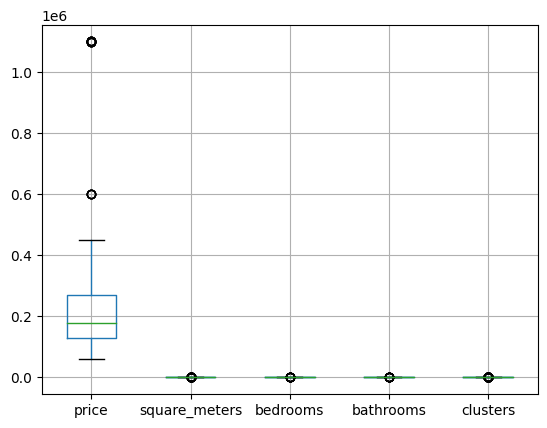

In [26]:
df_simple.boxplot()

In [27]:
data_cat = df_simple.select_dtypes(exclude=np.number)
data_num = df_simple.select_dtypes(np.number)
data_cat = data_cat.reset_index()

In [28]:
ss = StandardScaler()
data_num_scaled = pd.DataFrame(ss.fit_transform(data_num),columns=data_num.columns)
data_num_scaled = data_num_scaled.reset_index()
data_num_scaled.head()

,index,price,square_meters,bedrooms,bathrooms,clusters
0,0,0.435530,0.232057,0.567024,0.368456,-0.459982
1,1,-0.174610,-0.407978,-0.220139,0.368456,-0.459982
2,2,0.265752,-0.140779,0.567024,1.492884,-0.459982
3,3,-0.233236,-0.128351,0.567024,0.368456,-0.459982
4,4,-0.418666,-0.606824,-1.007301,-0.755971,0.492261


In [29]:
data_scaled=pd.concat([data_num_scaled,data_cat],axis=1).drop('index',axis=1)
data_scaled.head()

,price,square_meters,bedrooms,bathrooms,clusters,property_type
0,0.435530,0.232057,0.567024,0.368456,-0.459982,condo_apartment
1,-0.174610,-0.407978,-0.220139,0.368456,-0.459982,condo_apartment
2,0.265752,-0.140779,0.567024,1.492884,-0.459982,condo_apartment
3,-0.233236,-0.128351,0.567024,0.368456,-0.459982,condo_apartment
4,-0.418666,-0.606824,-1.007301,-0.755971,0.492261,condo_apartment


In [30]:
data_scaled = pd.get_dummies(data_scaled,columns=labeled_columns)
# Get the last 5 columns
last_columns = data_scaled.columns[-5:]

# Generate new column names
new_column_names = ["cluster_1", "cluster_2", "cluster_3", "cluster_4", "cluster_5"]

# Rename the last 5 columns
data_scaled.rename(columns=dict(zip(last_columns, new_column_names)), inplace=True)
data_scaled.head()

,price,square_meters,bedrooms,bathrooms,property_type_condo_apartment,property_type_single_family,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
0,0.435530,0.232057,0.567024,0.368456,1,0,0,1,0,0,0
1,-0.174610,-0.407978,-0.220139,0.368456,1,0,0,1,0,0,0
2,0.265752,-0.140779,0.567024,1.492884,1,0,0,1,0,0,0
3,-0.233236,-0.128351,0.567024,0.368456,1,0,0,1,0,0,0
4,-0.418666,-0.606824,-1.007301,-0.755971,1,0,0,0,1,0,0


In [31]:
model=NearestNeighbors(metric='cosine')
model.fit(data_scaled)

NearestNeighbors(metric='cosine')

In [32]:
selected=7
data_scaled.iloc[selected].values[0:8]

array([-0.42397146, -0.26505747,  0.56702379, -0.75597089,  1.        ,
        0.        ,  0.        ,  1.        ])

In [33]:
dist,index = model.kneighbors(data_scaled.iloc[selected].values.reshape(1,-1),n_neighbors=6)
index

array([[ 16, 165,  81, 146, 306,   7]])

In [34]:
df_labeled = df_simple[labeled_columns]
df_labeled = pd.get_dummies(df_labeled,columns=labeled_columns)
df_labeled.head()

,property_type_condo_apartment,property_type_single_family,clusters_0,clusters_1,clusters_2,clusters_3,clusters_4
21200,1,0,0,1,0,0,0
21203,1,0,0,1,0,0,0
21204,1,0,0,1,0,0,0
21476,1,0,0,1,0,0,0
21851,1,0,0,0,1,0,0


In [39]:
def knn_jaccard(df, example, k=6):
  """Needs as an input labeled data as one-hot-encoding"""
  row2dist = []
  for i in tqdm(range(df.shape[0])):
    jacc = jaccard_score(np.array(df.iloc[i]), example)
    row2dist.append((i, jacc))
  row2dist.sort(key=lambda x: x[1], reverse=True)
  return row2dist[0:k]

res = knn_jaccard(df_labeled, df_labeled.iloc[3])

100%|██████████| 354/354 [00:01<00:00, 284.12it/s]


In [40]:
res

[(0, 1.0), (1, 1.0), (2, 1.0), (3, 1.0), (5, 1.0), (6, 1.0)]

In [49]:
def similar_properties(id, df_num, df_labels, k):
  k1 = k//2
  k2 = k-k1
  recommended_labs = knn_jaccard(df_labels, df_labels.iloc[id] ,k=k1)
  dist, recommended_nums = model.kneighbors(df_num.iloc[id].values.reshape(1,-1),n_neighbors=k2)
  recommended_nums = recommended_nums[0]
  return [a[0] for a in recommended_labs]+list(recommended_nums)
similar_properties(2, data_scaled, df_labeled, k=5)

100%|██████████| 354/354 [00:01<00:00, 285.81it/s]

[0, 1]
[2, 11, 76]


[0, 1, 2, 11, 76]